In [1]:
import torch
import torchvision

import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Hyperparameters
batch_size = 64
learning_rate = 0.001
num_epochs = 10

# Data preprocessing and loading
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=False)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=False)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Define the CNN model with dropout
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(7 * 7 * 128, 1000)
        self.fc2 = nn.Linear(1000, 10)

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.conv2(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

model = CNN()
#device CPU or GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training the model
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

model.to(device)
for epoch in range(num_epochs):
    model.train()
    correct = 0
    total = 0
    train_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(100 * correct / total)
    
    model.eval()
    correct = 0
    total = 0
    test_loss = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(100 * correct / total)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss/len(train_loader):.4f}, Test Loss: {test_loss/len(test_loader):.4f}, Train Accuracy: {100 * correct / total:.2f}%, Test Accuracy: {100 * correct / total:.2f}%')

cuda:0
Epoch [1/10], Train Loss: 0.2735, Test Loss: 0.0547, Train Accuracy: 98.17%, Test Accuracy: 98.17%
Epoch [2/10], Train Loss: 0.1251, Test Loss: 0.0527, Train Accuracy: 98.37%, Test Accuracy: 98.37%
Epoch [3/10], Train Loss: 0.1025, Test Loss: 0.0412, Train Accuracy: 98.76%, Test Accuracy: 98.76%
Epoch [4/10], Train Loss: 0.0887, Test Loss: 0.0378, Train Accuracy: 98.75%, Test Accuracy: 98.75%
Epoch [5/10], Train Loss: 0.0783, Test Loss: 0.0398, Train Accuracy: 98.60%, Test Accuracy: 98.60%
Epoch [6/10], Train Loss: 0.0714, Test Loss: 0.0314, Train Accuracy: 99.09%, Test Accuracy: 99.09%
Epoch [7/10], Train Loss: 0.0652, Test Loss: 0.0380, Train Accuracy: 98.88%, Test Accuracy: 98.88%
Epoch [8/10], Train Loss: 0.0615, Test Loss: 0.0318, Train Accuracy: 99.05%, Test Accuracy: 99.05%
Epoch [9/10], Train Loss: 0.0589, Test Loss: 0.0353, Train Accuracy: 98.85%, Test Accuracy: 98.85%
Epoch [10/10], Train Loss: 0.0546, Test Loss: 0.0313, Train Accuracy: 98.98%, Test Accuracy: 98.98%


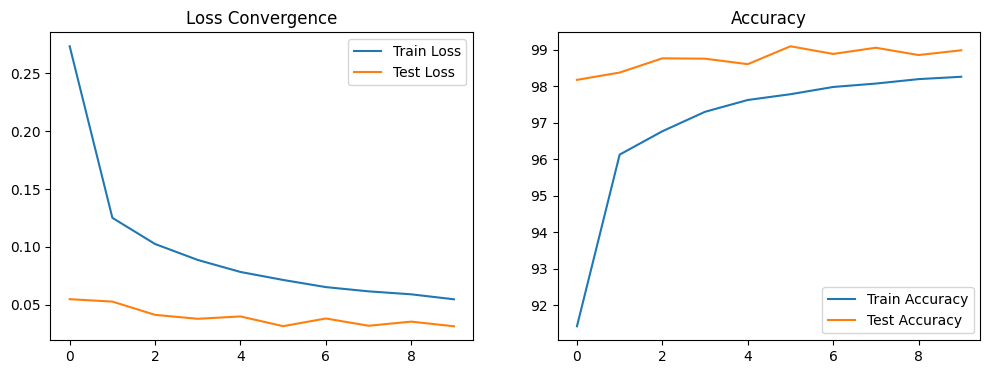

In [2]:
# Plotting the results
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.title('Loss Convergence')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

In [3]:
from torchsummary import summary
model.to(device)
print(next(model.parameters()).is_cuda)
summary(model, input_size=(1, 28, 28), batch_size=batch_size)

True
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [64, 64, 28, 28]           1,664
              ReLU-2           [64, 64, 28, 28]               0
         MaxPool2d-3           [64, 64, 14, 14]               0
            Conv2d-4          [64, 128, 14, 14]         204,928
              ReLU-5          [64, 128, 14, 14]               0
         MaxPool2d-6            [64, 128, 7, 7]               0
           Dropout-7                 [64, 6272]               0
            Linear-8                 [64, 1000]       6,273,000
            Linear-9                   [64, 10]          10,010
Total params: 6,489,602
Trainable params: 6,489,602
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 86.24
Params size (MB): 24.76
Estimated Total Size (MB): 111.19
------------------------------

In [4]:
img_idx = 1234
test_dataset[img_idx][0].shape, test_dataset[img_idx][1]

(torch.Size([1, 28, 28]), 8)

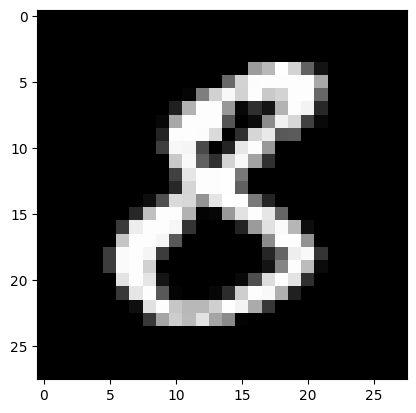

In [5]:
plt.imshow(test_dataset[img_idx][0].cpu().reshape(28, 28), cmap='gray')
plt.show()

In [6]:
first_layer = nn.Sequential(*list(model.children())[:1])
first_layer_output = first_layer(test_dataset[img_idx][0].reshape(1, 1, 28, 28).to(device)).cpu().detach()
first_layer_output.shape

torch.Size([1, 64, 28, 28])

In [7]:
first_layer

Sequential(
  (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
)

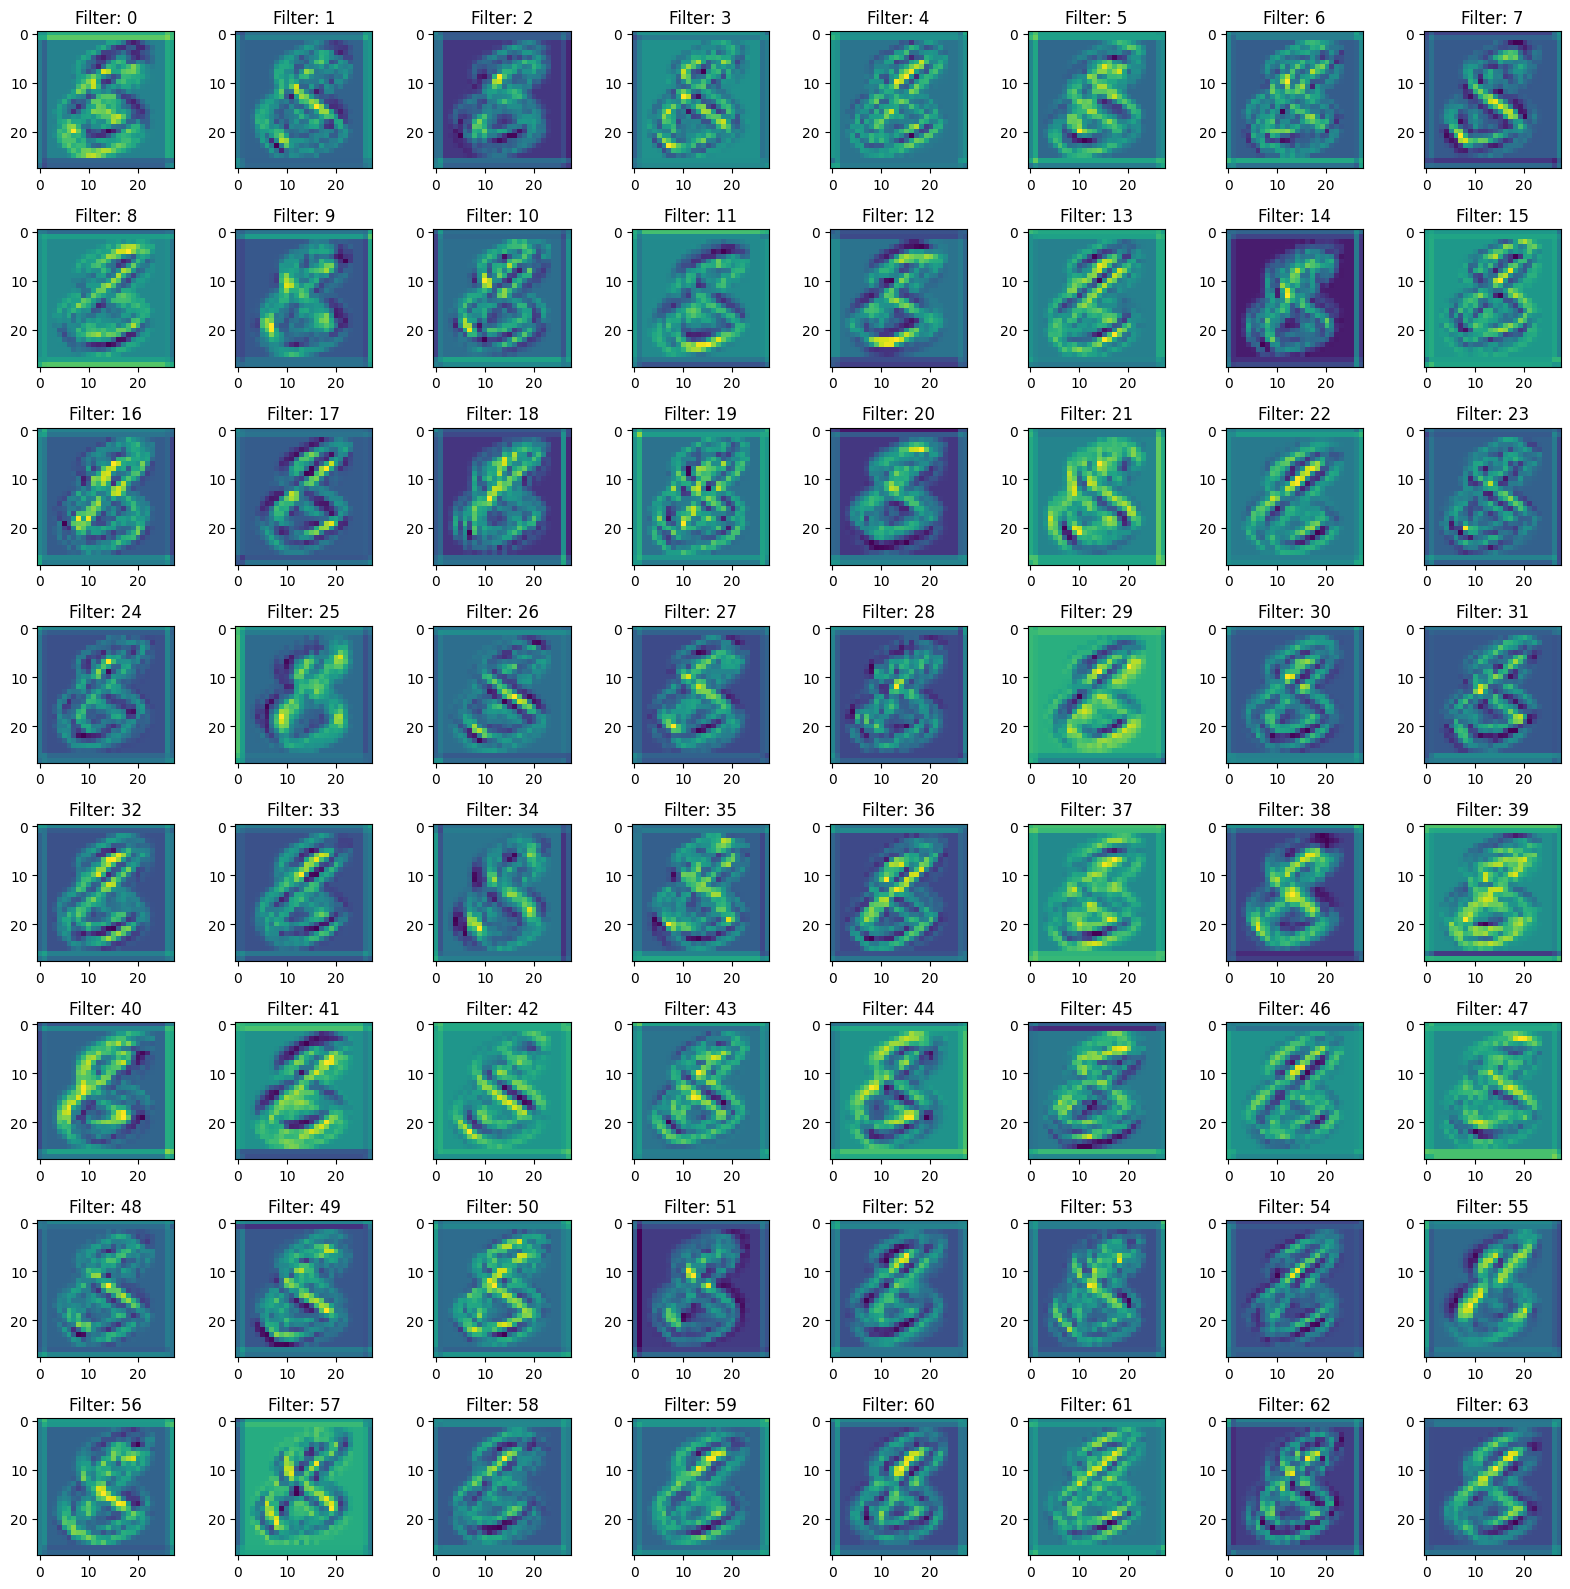

In [8]:
fig, ax = plt.subplots(8, 8, figsize=(16,16))
for ix, axis in enumerate(ax.flat):
    axis.set_title('Filter: '+str(ix))
    axis.imshow(first_layer_output[0][ix].reshape(28,28).cpu())
plt.tight_layout()
plt.show()